# Test Checkpoint Loading

This notebook tests loading a trained model from checkpoint and running inference on the validation set.


In [1]:
# Imports
import os
import sys
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from src.mamba.train_functions import collate_fn, get_predictions
import matplotlib.pyplot as plt

# Add parent directory to path to import mamba_model
notebook_dir = Path.cwd()
if 'cv_training' in str(notebook_dir):
    mamba_dir = notebook_dir.parent
else:
    mamba_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd() / 'src' / 'mamba'

sys.path.insert(0, str(mamba_dir))
from src.mamba.mamba_model import TrajectoryMambaModel, ModelArgs
from src.mamba.trajectory_dataloader import TrajectoryDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

%load_ext autoreload
%autoreload 2


Using device: cuda


In [2]:
# Configuration - must match training configuration
notebook_path = Path.cwd()
if 'cv_training' in str(notebook_path):
    data_dir = notebook_path / 'data' / 'data'
    checkpoint_dir = notebook_path / 'checkpoints'
else:
    data_dir = Path('cv_training/data/data')
    checkpoint_dir = Path('cv_training/checkpoints')

config = {
    # Data
    'data_dir': str(data_dir),
    'train_split': 0.8,
    'val_split': 0.2,
    
    # Data Dimensions
    'input_dim': 2,
    'num_classes': 3,
    
    # Model "Brain" Dimensions - must match training
    'd_model': 64,
    'n_layer': 4,
    'd_state': 16,
    'expand': 2,
    
    # DataLoader
    'batch_size': 32,
    'min_seq_length': 2,
    'num_workers': 0,
    'seed': 42
}

# Set random seed
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")


Configuration:
  data_dir: cv_training\data\data
  train_split: 0.8
  val_split: 0.2
  input_dim: 2
  num_classes: 3
  d_model: 64
  n_layer: 4
  d_state: 16
  expand: 2
  batch_size: 32
  min_seq_length: 2
  num_workers: 0
  seed: 42


In [3]:
# Load dataset and create validation loader
data_path = Path(config['data_dir'])
if not data_path.exists():
    raise ValueError(f"Data directory not found: {data_path}")

dataset = TrajectoryDataset(str(data_path))
print(f"Total trajectories: {len(dataset)}")

# Split into train and validation (same split as training)
train_size = int(config['train_split'] * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], 
                                         generator=torch.Generator().manual_seed(config['seed']))

print(f"Train trajectories: {len(train_dataset)}")
print(f"Validation trajectories: {len(val_dataset)}")

# Create validation dataloader
val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    collate_fn=collate_fn
)


Total trajectories: 16000
Train trajectories: 12800
Validation trajectories: 3200


In [4]:
# Create model with same architecture as training
model_args = ModelArgs(
    d_model=config['d_model'],
    n_layer=config['n_layer'],
    d_state=config['d_state'],
    expand=config['expand']
)

model = TrajectoryMambaModel(model_args, input_dim=config["input_dim"]).to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")


Model created with 126594 parameters


In [5]:
# Load checkpoint
checkpoint_path = checkpoint_dir / 'checkpoint_epoch_5.pt'
if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

print(f"Loading checkpoint from: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load model state dict
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Model loaded successfully!")
print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"  Train Loss: {checkpoint.get('train_loss', 'N/A'):.6f}")
print(f"  Val Loss: {checkpoint.get('val_loss', 'N/A'):.6f}")

# Set model to evaluation mode
model.eval()


Loading checkpoint from: cv_training\checkpoints\checkpoint_epoch_5.pt
✓ Model loaded successfully!
  Epoch: 4
  Train Loss: 0.002565
  Val Loss: 0.002310


TrajectoryMambaModel(
  (encoder): Linear(in_features=2, out_features=64, bias=True)
  (backbone): Mamba(
    (layers): ModuleList(
      (0-3): 4 x ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=64, out_features=256, bias=False)
          (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
          (x_proj): Linear(in_features=128, out_features=32, bias=False)
          (out_proj): Linear(in_features=128, out_features=64, bias=False)
        )
        (norm): RMSNorm()
      )
    )
    (norm_f): RMSNorm()
  )
  (pred_head): Linear(in_features=64, out_features=2, bias=True)
)

In [6]:
# Run inference on validation set
results = get_predictions(model, val_loader, device)
print(f"\n✓ Inference completed!")
print(f"  Total trajectories: {len(results['preds'])}")


Generating predictions...
Retrieving traj 12161
Retrieved traj 12161
Retrieving traj 13142
Retrieved traj 13142
Retrieving traj 5684
Retrieved traj 5684
Retrieving traj 1556
Retrieved traj 1556
Retrieving traj 2798
Retrieved traj 2798
Retrieving traj 12296
Retrieved traj 12296
Retrieving traj 7197
Retrieved traj 7197
Retrieving traj 9634
Retrieved traj 9634
Retrieving traj 704
Retrieved traj 704
Retrieving traj 9565
Retrieved traj 9565
Retrieving traj 10773
Retrieved traj 10773
Retrieving traj 5203
Retrieved traj 5203
Retrieving traj 15599
Retrieved traj 15599
Retrieving traj 1244
Retrieved traj 1244
Retrieving traj 7940
Retrieved traj 7940
Retrieving traj 13238
Retrieved traj 13238
Retrieving traj 3858
Retrieved traj 3858
Retrieving traj 83
Retrieved traj 83
Retrieving traj 13264
Retrieved traj 13264
Retrieving traj 6361
Retrieved traj 6361
Retrieving traj 8266
Retrieved traj 8266
Retrieving traj 666
Retrieved traj 666
Retrieving traj 13183
Retrieved traj 13183
Retrieving traj 2305
Re

Global RMSE in Real Units: 0.9595


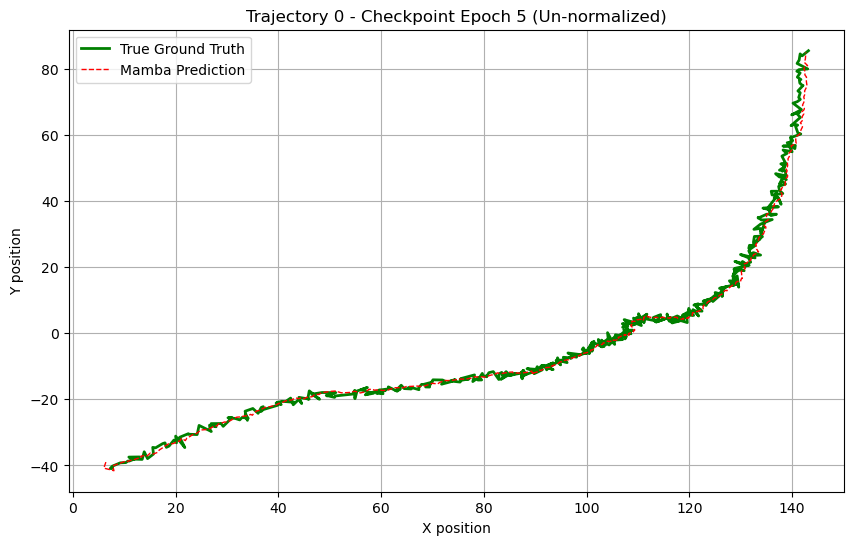


✓ Plot generated successfully!
  This confirms that checkpoint loading works correctly.


In [7]:
# Plot one trajectory and prediction (same as in train_mamba.ipynb)
idx = 0  # Plot first trajectory

pred_traj = results["preds"][idx]
true_traj = results["targets"][idx]
kf_data = results["kf_params"][idx]
real_positions = results["real_positions"][idx][1:]  # to match the dimensions of other measurements

# Calculate RMSE
all_preds_concat = np.concatenate([pred_traj], axis=0) if isinstance(pred_traj, list) else pred_traj
all_targets_concat = np.concatenate([true_traj], axis=0) if isinstance(true_traj, list) else true_traj

rmse = np.sqrt(np.mean((all_preds_concat - all_targets_concat)**2))
print(f"Global RMSE in Real Units: {rmse:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(true_traj[:, 0], true_traj[:, 1], 'g-', label='True Ground Truth', linewidth=2)
plt.plot(pred_traj[:, 0], pred_traj[:, 1], 'r--', label='Mamba Prediction', linewidth=1)
plt.title(f"Trajectory {idx} - Checkpoint Epoch 5 (Un-normalized)")
plt.legend()
plt.grid(True)
plt.xlabel('X position')
plt.ylabel('Y position')
plt.show()

print(f"\n✓ Plot generated successfully!")
print(f"  This confirms that checkpoint loading works correctly.")
